# Homework 2

**The following notebook is meant to help you work through Problems 1 and 3 on Homework 2. You are by no means required to use it, nor are you required to fill out/use any of the boilerplate code/functions. You are welcome to implement the functions however you wish.**


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as c
import matplotlib.patches as mpatches
from scipy.special import expit as sigmoid
from scipy.special import softmax
from scipy.special import logsumexp

In [6]:
# loading data

# data for Problem 1
t_obs, y_obs = np.genfromtxt("data/planet-obs.csv", delimiter = ',').T
t_obs = np.split(t_obs, 10)
y_obs = np.split(y_obs.reshape(-1, 1), 10)

# data for Problem 3
data = pd.read_csv("data/hr.csv")
mapper = {
    "Dwarf": 0,
    "Giant": 1,
    "Supergiant": 2
}
data['Type'] = data['Type'].map(mapper)

X_stars = data[['Magnitude', 'Temperature']].values
y_stars = data['Type'].values

from T2_P1_TestCases import test_p1
from T2_P3_TestCases import test_p3_softmax, test_p3_knn

# Problem 1

## Problem 1 Subpart 1

In [7]:
def basis1(t):
    return np.stack([np.ones(len(t)), t], axis=1)

def basis2(t):
    """
    Transform t into basis [1, t, t^2]

    :param t: a 1D numpy array of values to transform. Shape is (n,)
    :return: a 2D array in which each row corresponds to a basis transformation of
             an input value. Shape should be (n x 3)
    """
    return np.stack([np.ones(len(t)), t, t**2], axis=1)

def basis3(t):
    """
    Transform t into basis [1, t, t^2, t^3, t^4, t^5]

    :param t: a numpy array of values to transform. Shape is (n,)
    :return: a 2D array in which each row corresponds to a basis transformation of
             an input value. Shape should be (n x 6)
    """
    return np.stack([np.ones(len(t)), t, t**2, t**3, t**4, t**5], axis=1)

In [8]:
class LogisticRegressor:
    def __init__(self, eta, runs):
        self.eta = eta
        self.runs = runs
        self.W = None

    def fit(self, x, y, w_init):
        """
        Optimize the weights W to minimize the negative log-likelihood by using gradient descent

        :param x: a 2D numpy array of transformed feature values. Shape is (n x 2), (n x 3), or (n x 6)
        :param y: a 2D numpy array of output values. Shape is (n x 1)
        :param w_init: a 2D numpy array that initializes the weights. Shape is (d x 1), where d is the number of dimensions of transformed feature values. 
        :return: None
        """
        self.W = w_init
        for _ in range(self.runs):
            y_pred = sigmoid(x @ self.W)
            gradient = -x.T.dot(y - y_pred) / x.shape[0]
            self.W -= self.eta * gradient

    def predict(self, x):
        """
        Predict classification probability of transformed input x
        
        :param x: a 2D numpy array of transformed feature values. Shape is (n x 2), (n x 3), or (n x 6)
        :return: a 2D numpy array of predicted probabilities given current weights. Shape should be (n x 1)
        """
        return sigmoid(x @ self.W)


In [9]:
test_p1(LogisticRegressor, basis1, basis2, basis3)

Your test case results are, for basis 1, 2, and 3 respectively: Pass Pass Pass


Note: Students have reported local issues with passing the basis 3 test case. Try running on Google Colab if only basis 3 test is failing.  

## Plotting Functions for Problem 1, Subpart 2

In [10]:
# Function to visualize prediction lines
# Takes as input last_x, last_y, [list of models], basis function, title
# last_x and last_y should specifically be the dataset that the last model
# in [list of models] was trained on
def visualize_prediction_lines(last_x, last_y, models, basis, title):
    # Plot setup
    green = mpatches.Patch(color='green', label='Ground truth model')
    black = mpatches.Patch(color='black', label='Mean of learned models')
    purple = mpatches.Patch(color='purple', label='Model learned from displayed dataset')
    plt.legend(handles=[green, black, purple], loc='lower right')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Observed')
    plt.axis([0, 6, -.1, 1.1]) # Plot ranges

    # Plot dataset that last model in models (models[-1]) was trained on
    cmap = c.ListedColormap(['r', 'b'])
    plt.scatter(last_x, last_y, c=last_y, cmap=cmap, linewidths=1, edgecolors='black')

    # Plot models
    X_pred = np.linspace(0, 6, 1000)
    X_pred_transformed = basis(X_pred)

    ## Ground truth model
    plt.plot(X_pred, np.cos(1.1*X_pred + 1) * 0.4 + 0.5, 'g', linewidth=5)

    ## Individual learned logistic regressor models
    Y_hats = []
    for i in range(len(models)):
        model = models[i]
        Y_hat = model.predict(X_pred_transformed)
        Y_hats.append(Y_hat)
        if i < len(models) - 1:
            plt.plot(X_pred, Y_hat, linewidth=.3)
        else:
            plt.plot(X_pred, Y_hat, 'purple', linewidth=3)

    # Mean / expectation of learned models over all datasets
    plt.plot(X_pred, np.mean(Y_hats, axis=0), 'k', linewidth=5)

    plt.savefig(title + '.png')
    plt.show()

In [11]:
# You may find it helpful to modify this function for Problem 1, Subpart 4,
# but do not change the existing code--add your own variables
def plot_results(basis, title):
    eta = 0.001
    runs = 10000

    test_points = [0.1, 3.2]
    predictions = {t: [] for t in test_points}

    all_models = []
    for i in range(10):
        x, y = t_obs[i], y_obs[i]
        x_transformed = basis(x)
        model = LogisticRegressor(eta=eta, runs=runs)
        model.fit(x_transformed, y, np.zeros((x_transformed.shape[1], 1)))
        all_models.append(model)

        for t in test_points:
            t_transformed = basis(np.array([t]))
            pred = model.predict(t_transformed)[0]
            predictions[t].append(pred)
    
    for t in test_points:
        model_pred = predictions[t][0]
        variance = np.var(predictions[t])
        print(f"Test point {t}: First model prediction = {model_pred}, Variance = {variance}")


    visualize_prediction_lines(x, y, all_models, basis, title)

Test point 0.1: First model prediction = [0.34826597], Variance = 0.004982612148989635
Test point 3.2: First model prediction = [0.60743925], Variance = 0.005660057219763854


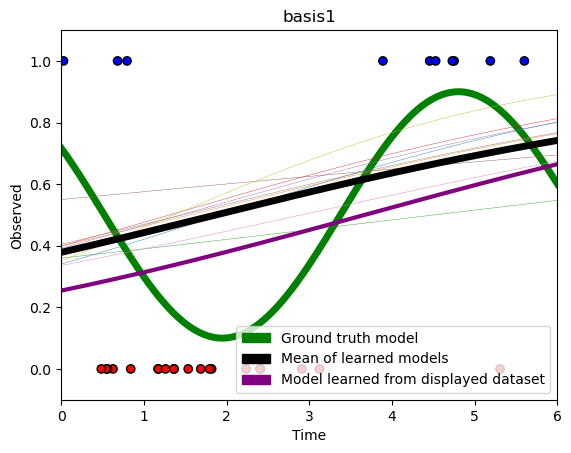

Test point 0.1: First model prediction = [0.36868564], Variance = 0.004553009312745909
Test point 3.2: First model prediction = [0.44202576], Variance = 0.011807015051122489


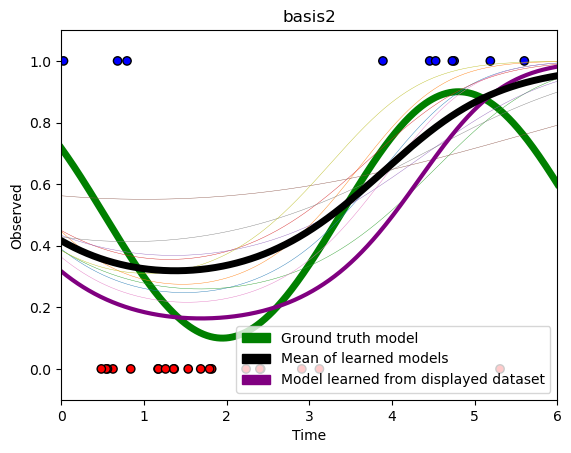

Test point 0.1: First model prediction = [0.51981078], Variance = 0.00338962316873776
Test point 3.2: First model prediction = [1.], Variance = 0.23282232401975583


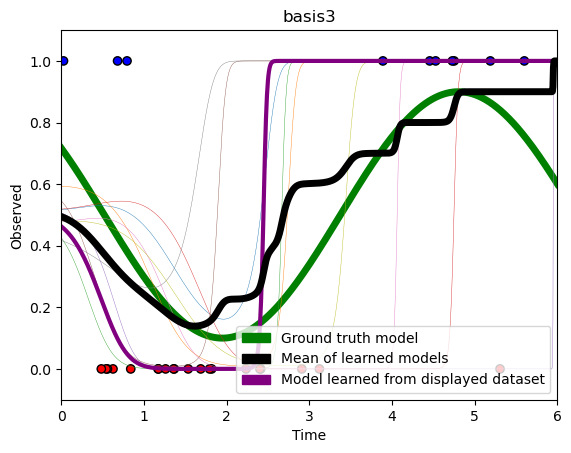

In [12]:
plot_results(basis1, 'basis1')
plot_results(basis2, 'basis2')
plot_results(basis3, 'basis3')

In [13]:
# Load the datasets
planet_obs = pd.read_csv('data/planet-obs.csv')
planet_obs_alternate = pd.read_csv('data/planet-obs-alternate.csv')

# Clean the data
planet_obs.columns = planet_obs.columns.str.strip()  # Remove any leading/trailing whitespaces
planet_obs_alternate.columns = planet_obs_alternate.columns.str.strip()  # Remove any leading/trailing whitespaces

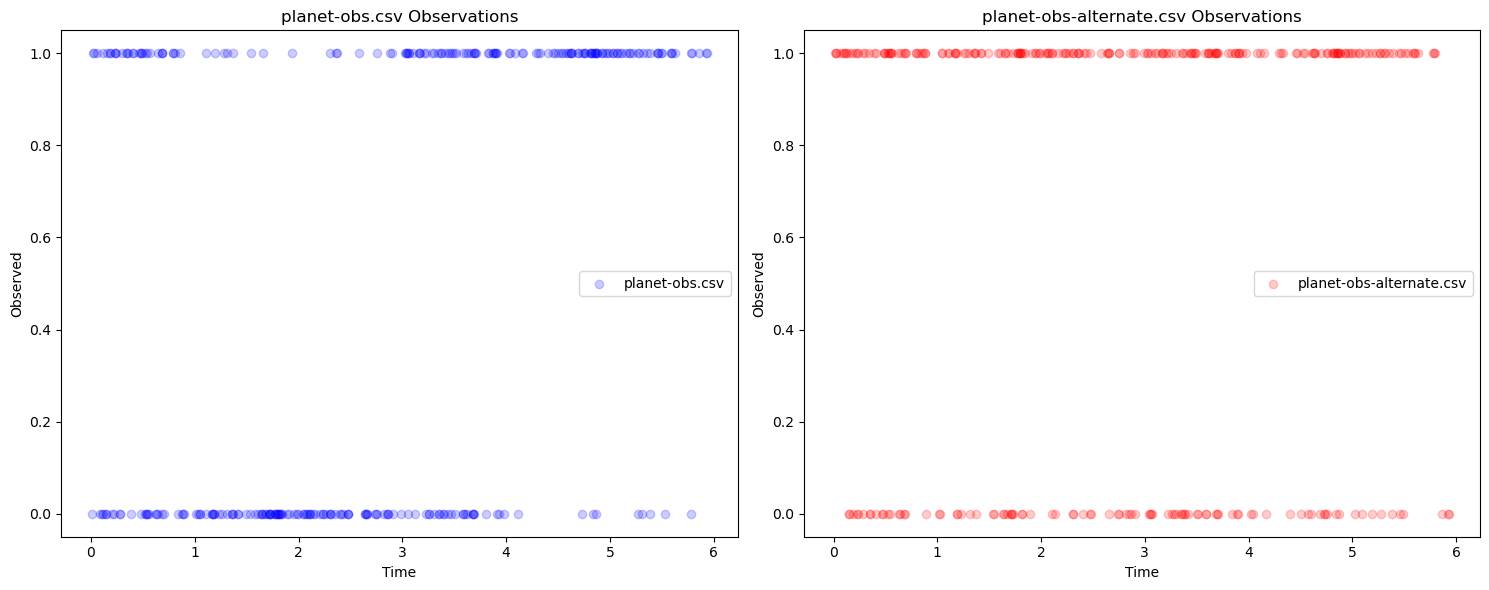

In [14]:
# Compare the observations side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot for planet-obs.csv
axs[0].scatter(planet_obs['# Time'], planet_obs['Observed'], color='blue', label='planet-obs.csv', alpha=0.2)
axs[0].set_title('planet-obs.csv Observations')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Observed')
axs[0].legend()

# Plot for planet-obs-alternate.csv
axs[1].scatter(planet_obs_alternate['# Time'], planet_obs_alternate['Observed'], color='red', label='planet-obs-alternate.csv', alpha=0.2)
axs[1].set_title('planet-obs-alternate.csv Observations')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Observed')
axs[1].legend()

plt.tight_layout()
plt.show()


# Problem 3

### Problem 3(a) & 3(b) - Gaussian Generative Model with & without shared covariance

In [28]:
class GaussianGenerativeModel:
    def __init__(self, is_shared_covariance=False):
        self.is_shared_covariance = is_shared_covariance

    def fit(self, X, y):
        """
        Compute the means and shared covariance matrix of the data. Compute the prior over y.
        
        :param X: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :param y: a 1D numpy array of target values (Dwarf=0, Giant=1, Supergiant=2).
        :return: None
        """
        self.classes = np.unique(y)
        self.class_means = {}
        self.priors = {}
        
        # Compute means for each class
        for cls in self.classes:
            X_cls = X[y == cls]
            self.class_means[cls] = np.mean(X_cls, axis=0)
            self.priors[cls] = X_cls.shape[0] / X.shape[0]
        
        if self.is_shared_covariance:
            # Compute shared covariance matrix for all classes
            # covariance * # records / # records
            cov_matrices = [np.cov(X[y == cls], rowvar=False) * np.sum(y == cls) for cls in self.classes]
            total_points = np.sum([np.sum(y == cls) for cls in self.classes])
            self.covariance = np.sum(cov_matrices, axis=0) / total_points
        else:
            # Compute separate covariance matrix for each class
            self.covariance = {cls: np.cov(X[y == cls], rowvar=False) for cls in self.classes}

    def predict(self, X_pred):
        """
        The code in this method should be removed and replaced! We included it
        just so that the distribution code is runnable and produces a
        (currently meaningless) visualization.
        
        Predict classes of points given feature values in X_pred
        
        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 1D numpy array of predicted classes (Dwarf=0, Giant=1, Supergiant=2).
                 Shape should be (n,)
        """
        d = X_pred.shape[1]  # Dimensionality of the feature vectors
        preds = []
        for x in X_pred:
            posteriors = []
            for cls in self.classes:
                # Calculate covariance matrix values
                cov_matrix = self.covariance[cls] if not self.is_shared_covariance else self.covariance
                cov_inv = np.linalg.inv(cov_matrix) 
                cov_det = np.linalg.det(cov_matrix)  
                
                # Use normal PDF to find class-conditional probs
                diff = x - self.class_means[cls]
                class_conditional = np.exp(-0.5 * diff.T @ cov_inv @ diff) / ((2 * np.pi) ** (d / 2) * cov_det ** 0.5)
                
                # Use Bayes (class-conditional * prior) to find posterior prob
                posterior = class_conditional * self.priors[cls]
                posteriors.append(posterior)

            # Append the highest class posterior prob 
            preds.append(np.argmax(posteriors))
        return np.array(preds)

    def negative_log_likelihood(self, X, y):
        """
        Given the data X, use previously calculated class means and covariance matrix to 
        calculate the negative log likelihood of the data
        """
        nll = 0
        # Use log-likelihood formula from problem 2, set negativ
        for cls in self.classes:
            X_cls = X[y == cls]
            diff = X_cls - self.class_means[cls]
            cov_matrix = self.covariance[cls] if not self.is_shared_covariance else self.covariance
            cov_inv = np.linalg.inv(cov_matrix)
            cov_det = np.linalg.det(cov_matrix)
            for i in range(X_cls.shape[0]):
                nll += 0.5 * np.log(cov_det) + 0.5 * diff[i].T @ cov_inv @ diff[i] - np.log(self.priors[cls])
        return nll


### Problem 3(c) & 3(d) - Multiclass Logistic Regression Classifier with softmax & basis

In [16]:
def one_hot(h, K):
    n_samples = h.shape[0]
    y_onehot = np.zeros((n_samples, K))
    y_onehot[np.arange(n_samples), h] = 1
    return y_onehot

class SoftmaxRegression:
    def __init__(self, eta, lam):
        self.eta = eta
        self.lam = lam
        self.W = None

    def fit(self, X, y):
        """
        Fit the weights W of softmax regression using gradient descent with L2 regularization
        Use the results from Problem 2 to find an expression for the gradient
        
        :param X: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :param y: a 1D numpy array of target values (Dwarf=0, Giant=1, Supergiant=2).
        :return: None
        """

        X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1) # Adding bias term to the features
        
        # Initializing the weights (do not change!)
        # The number of classes is 1 + (the highest numbered class)
        num_classes = 1 + y.max()
        num_features = X.shape[1]
        self.W = np.ones((num_classes, num_features))

        for _ in range(200000):
            y_hat = np.dot(X, self.W.T)
            y_onehot = one_hot(y, num_classes)
            s = softmax(y_hat, axis=1)
            
            gradient = np.dot((s - y_onehot).T, X)
            gradient += self.lam * self.W

            self.W -= self.eta * gradient


    def predict(self, X_pred):
        """
        The code in this method should be removed and replaced! We included it
        just so that the distribution code is runnable and produces a
        (currently meaningless) visualization.
        
        Predict classes of points given feature values in X_pred
        
        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 1D numpy array of predicted classes (Dwarf=0, Giant=1, Supergiant=2).
                 Shape should be (n,)
        """     
        X_pred = np.concatenate((np.ones((X_pred.shape[0], 1)), X_pred), axis=1)
        scores = np.dot(X_pred, self.W.T)
        probs = softmax(scores)
        y_pred = np.argmax(probs, axis=1)
        return y_pred
    
    def predict_proba(self, X_pred):
        """    
        Predict classification probabilities of points given feature values in X_pred
        
        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 2D numpy array of predicted class probabilities (Dwarf=index 0, Giant=index 1, Supergiant=index 2).
                 Shape should be (n x 3)
        """
        X_pred = np.concatenate((np.ones((X_pred.shape[0], 1)), X_pred), axis=1)
        scores = np.dot(X_pred, self.W.T)
        probs = softmax(scores)
        return probs

#### For 3(d) - basis function

In [17]:
def phi(X):
    """
    Transform [x_1, x_2] into basis [ln(x_1 + 10), x_2^2]

    :param t: a 2D numpy array of values to transform. Shape is (n x 2)
    :return: a 2D array in which each row corresponds to a basis transformation of
             an input value. Shape should be (n x 2)
    """
    return np.array([[np.log(x[0] + 10), x[1]**2] for x in X])

### Problem 3(e) - kNN Classifier

In [18]:
class KNNClassifier:
    def __init__(self, k):
        self.X = None
        self.y = None
        self.K = k

    def distance(self, x1, x2):
        return ((x1[0] - x2[0])**2)/9 + (x1[1] - x2[1])**2
        
    def fit(self, X, y):
        """
        In KNN, "fitting" can be as simple as storing the data, so this has been written for you.
        If you'd like to add some preprocessing here without changing the inputs, feel free,
        but this is completely optional.
        """
        self.X = X
        self.y = y

    def predict(self, X_pred):
        """
        The code in this method should be removed and replaced! We included it
        just so that the distribution code is runnable and produces a
        (currently meaningless) visualization.
        
        Predict classes of points given feature values in X_pred
        
        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 1D numpy array of predicted classes (Dwarf=0, Giant=1, Supergiant=2).
                 Shape should be (n,)
        """
        preds = []
        for x1 in X_pred:
            # Calculate distances from x1 to all points in self.X
            distances = [self.distance(x1, x2) for x2 in self.X]
            nearest_indices = np.argsort(distances)[:self.K]
            nearest_labels = self.y[nearest_indices]
            label_counts = np.bincount(nearest_labels)
            pred_label = np.argmax(label_counts)
            preds.append(pred_label)
        preds = np.array(preds)
        return preds


## Plotting Function for Problem 3, Subpart 1

In [19]:
# Visualize the decision boundary that a model produces
def visualize_boundary(model, X, y, title, basis=None, width=2):
    # Create a grid of points
    x_min, x_max = min(X[:, 0] - width), max(X[:, 0] + width)
    y_min, y_max = min(X[:, 1] - width), max(X[:, 1] + width)
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, 0.05),
        np.arange(y_min, y_max, 0.05)
    )

    # Flatten the grid so the values match spec for self.predict
    xx_flat = xx.flatten()
    yy_flat = yy.flatten()
    X_pred = np.vstack((xx_flat, yy_flat)).T
    
    if basis is not None:
        X_pred = basis(X_pred)

    # Get the class predictions
    Y_hat = model.predict(X_pred)
    Y_hat = Y_hat.reshape((xx.shape[0], xx.shape[1]))

    # Visualize them.
    cmap = c.ListedColormap(['r', 'b', 'g'])
    plt.figure()
    plt.title(title)
    plt.xlabel('Magnitude')
    plt.ylabel('Temperature')
    plt.pcolormesh(xx, yy, Y_hat, cmap=cmap, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, linewidths=1,
                edgecolors='black')

    # Adding a legend and a title
    red = mpatches.Patch(color='red', label='Dwarf')
    blue = mpatches.Patch(color='blue', label='Giant')
    green = mpatches.Patch(color='green', label='Supergiant')
    plt.legend(handles=[red, blue, green])

    # Saving the image to a file, and showing it as well
    plt.savefig(title + '.png')
    plt.show()

## Problem 3, Subpart 1

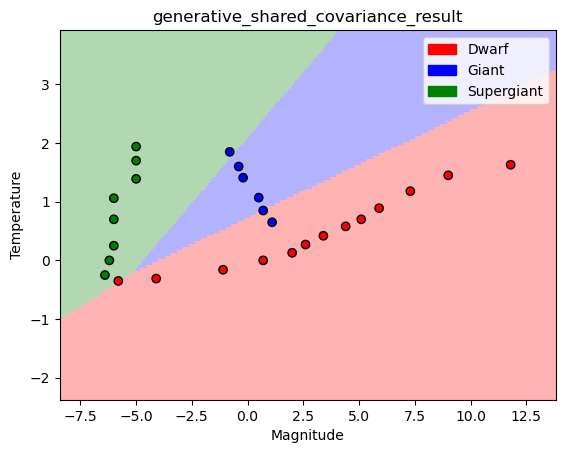

In [29]:
generative_model = GaussianGenerativeModel(is_shared_covariance=True)
generative_model.fit(X_stars, y_stars)
visualize_boundary(model=generative_model,
                   X=X_stars,
                   y=y_stars,
                   title='generative_shared_covariance_result',
                   basis=None)


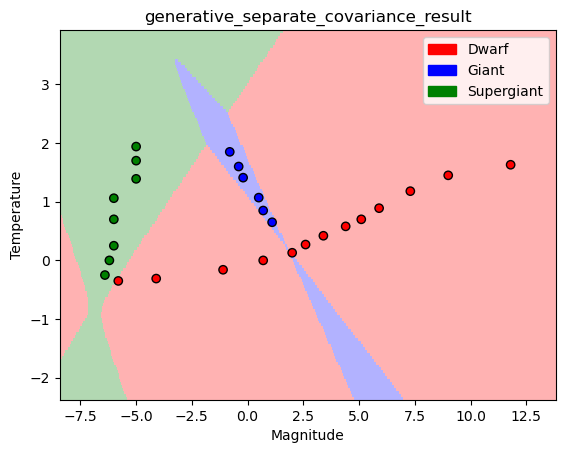

In [21]:
generative_model_2 = GaussianGenerativeModel(is_shared_covariance=False)
generative_model_2.fit(X_stars, y_stars)
visualize_boundary(model=generative_model_2,
                   X=X_stars,
                   y=y_stars,
                   title='generative_separate_covariance_result',
                   basis=None)

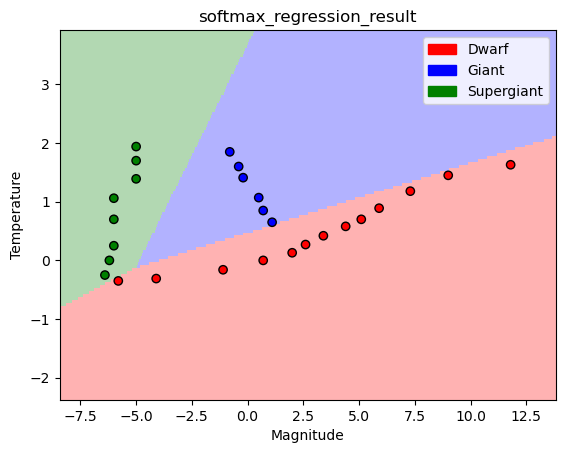

In [22]:
# Example of fitting a model and visualizing the decision boundaries;
# do this for each of the four models
softmax_model = SoftmaxRegression(eta=0.001, lam=0.001)
softmax_model.fit(X_stars, y_stars)
visualize_boundary(model=softmax_model,
                   X=X_stars,
                   y=y_stars,
                   title='softmax_regression_result',
                   basis=None)

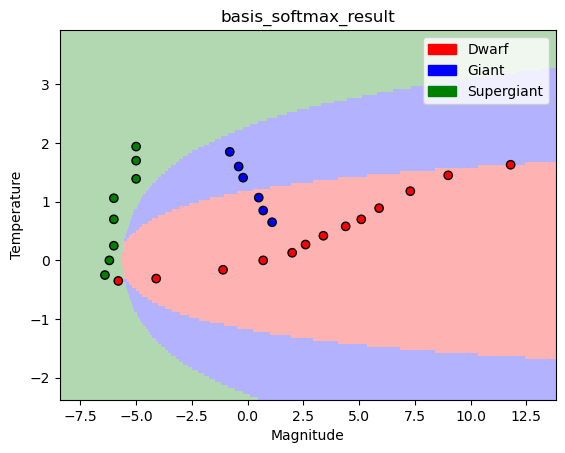

In [23]:
basis_model = SoftmaxRegression(eta=0.001, lam=0.001)
basis_model.fit(phi(X_stars), y_stars)
visualize_boundary(model=basis_model,
                   X=X_stars,
                   y=y_stars,
                   title='basis_softmax_result',
                   basis=phi)

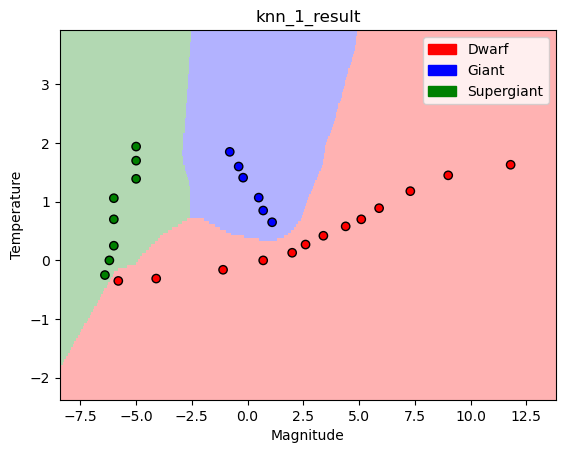

In [24]:
knn1_model = KNNClassifier(1)
knn1_model.fit(X_stars, y_stars)
visualize_boundary(model=knn1_model,
                   X=X_stars,
                   y=y_stars,
                   title='knn_1_result',
                   basis=None)

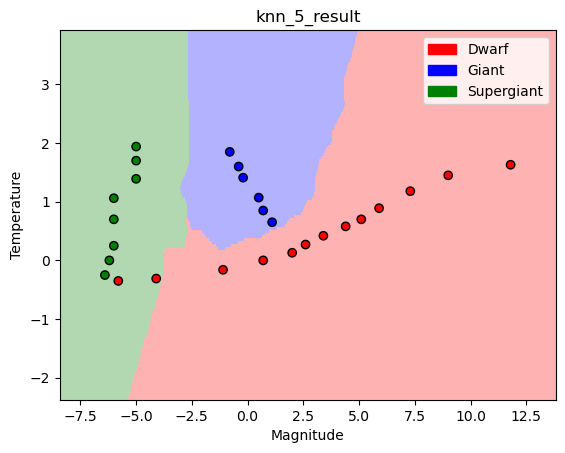

In [25]:
knn5_model = KNNClassifier(5)
knn5_model.fit(X_stars, y_stars)
visualize_boundary(model=knn5_model,
                   X=X_stars,
                   y=y_stars,
                   title='knn_5_result',
                   basis=None)

In [26]:
print("Softmax Model Weights:")
print(softmax_model.W)
print("\nBasis Model Weights:")
print(basis_model.W)

Softmax Model Weights:
[[ 12.15017629   3.47210612 -15.42828769]
 [  1.39298188   0.77670128   7.24822137]
 [-11.08696616  -1.79261539  10.63625833]]

Basis Model Weights:
[[-8.92385352  7.42722582 -0.98134517]
 [-5.27856831  4.90931462  0.55637611]
 [16.65861384 -9.88034843  2.88116108]]


In [27]:
# test your models by passing your fitted models into the functions below
# softmax_model is an instance of class SoftmaxRegression fitted to data X_stars, y_stars
# basis_model is an instance of class SoftmaxRegression fitted to data phi(X_stars), y_stars
# knn1_model is an instance of class KNNClassifier with parameter k=1
# knn5_model is an instance of class KNNClassifier with parameter k=5
test_p3_softmax(softmax_model, basis_model)
test_p3_knn(knn1_model, knn5_model)

Passed softmax regression tests
Passed KNN tests
